In [2]:
import pandas as pd 
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import string

In [3]:
from google.colab import files 
uploaded = files.upload()

Saving testcsv.csv to testcsv.csv
Saving train.csv to train.csv


In [5]:
test = pd.read_csv('testcsv.csv')
train = pd.read_csv('train.csv')

In [6]:
train[train['text'].isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [7]:
train = train.dropna()
train[train['text'].isna()]

,textID,text,selected_text,sentiment


In [8]:
train['text'] = train['text'].apply(lambda x: x.lower())
test['text'] = test['text'].apply(lambda x: x.lower())

import re

# remove '\\n'
train['text'] = train['text'].map(lambda x: re.sub('\\n',' ',str(x)))
    
# remove any text starting with User... 
train['text'] = train['text'].map(lambda x: re.sub("\[\[User.*",'',str(x)))
    
# remove IP addresses or user IDs
train['text'] = train['text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    
#remove http links in the text
train['text'] = train['text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)",'',str(x)))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(
    train, train_size = 0.9, random_state = 0)

In [10]:
X_train.head(5)

,textID,text,selected_text,sentiment
13623,2a69c2fa17,my ex-colleagues from shaanxi kept boasting o...,I`m REALLY curious,positive
9384,d4eea7e328,sad day. i was lucky enough to realize it be...,sad day. I was lucky enough to realize it befo...,neutral
26276,b4410b1922,lol. no new diet plan...ran late for wrk so d...,lol. No new diet plan...ran late for wrk so di...,neutral
20298,5efd224f4e,happy mothers day to all im off to spend the...,happy,positive
14935,1990d1f25b,had to give my 5 year old golden retriever awa...,#sad,negative


In [11]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [12]:
import re
from nltk.stem import WordNetLemmatizer 

words = nltk.corpus.stopwords.words('english')
words.remove('no')
words.remove('not')
wn = WordNetLemmatizer() 

a = ['i','to','the','a','my','you','and','it','is','in','for','im','of','me','on','so','have','that','be','its','with','day','at','was']

i=1


def clean_txt(txt):
    new = ' '.join([w for w in txt.split() if len(w)>2])
    dup = re.sub(r'\b(\w+)( \1\b)+', r'\1', new)
    unw = " ".join([u for u in dup.split() if u.lower() not in a])
    txt = " ".join([wn.lemmatize(word) for word in unw.split()])
    alp = " ".join([d for d in txt.split() if d.lower() in words or not d.isalpha()])
    return alp

X_train['selected_text'] = X_train['selected_text'].apply(lambda x: clean_txt(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
X_train[:10]

,textID,text,selected_text,sentiment
13623,2a69c2fa17,my ex-colleagues from shaanxi kept boasting o...,I`m,positive
9384,d4eea7e328,sad day. i was lucky enough to realize it be...,day. before out lot.,neutral
26276,b4410b1922,lol. no new diet plan...ran late for wrk so d...,lol. plan...ran didn`t lunch. when hm!,neutral
20298,5efd224f4e,happy mothers day to all im off to spend the...,,positive
14935,1990d1f25b,had to give my 5 year old golden retriever awa...,#sad,negative
20655,03efda0e7e,i`m a minute in and i want to strangle the us...,I`m doing presentation. guy?,neutral
518,b41f647910,i miss her alot and its only been one day,,negative
10645,77c01f0add,"yes, that does sound like a distinct advantag...","Fortunately,",positive
20662,057b982878,really good concepts at #mozconcept. i *really...,"#mozconcept. *really* mine,",positive
8038,57a8f2f255,back from mountains,from,neutral


In [14]:
pos_train = X_train[X_train['sentiment'] == 'positive']
neutral_train = X_train[X_train['sentiment'] == 'neutral']
neg_train = X_train[X_train['sentiment'] == 'negative']

In [15]:
neutral_train.head(5)

,textID,text,selected_text,sentiment
9384,d4eea7e328,sad day. i was lucky enough to realize it be...,day. before out lot.,neutral
26276,b4410b1922,lol. no new diet plan...ran late for wrk so d...,lol. plan...ran didn`t lunch. when hm!,neutral
20655,03efda0e7e,i`m a minute in and i want to strangle the us...,I`m doing presentation. guy?,neutral
8038,57a8f2f255,back from mountains,from,neutral
2827,ede4721177,no credit left on my mobile sorry brit! *pounc...,Brit! *pounces back*,neutral


In [16]:
cv = CountVectorizer(analyzer='word',max_df=0.90, min_df=0.00,stop_words='english')

X_train_cv = cv.fit_transform(X_train['text'])

X_pos = cv.transform(pos_train['text'])
X_neutral = cv.transform(neutral_train['text'])
X_neg = cv.transform(neg_train['text'])


pos_count_df = pd.DataFrame(X_pos.toarray(), columns=cv.get_feature_names())
neutral_count_df = pd.DataFrame(X_neutral.toarray(), columns=cv.get_feature_names())
neg_count_df = pd.DataFrame(X_neg.toarray(), columns=cv.get_feature_names())

In [17]:
pos_words = {}
neutral_words = {}
neg_words = {}

for k in cv.get_feature_names():
    pos = pos_count_df[k].sum()
    neutral = neutral_count_df[k].sum()
    neg = neg_count_df[k].sum()
    pos_words[k] = pos/pos_train.shape[0]
    neutral_words[k] = neutral/neutral_train.shape[0]
    neg_words[k] = neg/neg_train.shape[0]
    
# We need to account for the fact that there will be a lot of words used in tweets of every sentiment.  
# Therefore, we reassign the values in the dictionary by subtracting the proportion of tweets in the other 
# sentiments that use that word.
neg_words_adj = {}
pos_words_adj = {}
neutral_words_adj = {}

for key, value in neg_words.items():
    neg_words_adj[key] = neg_words[key] - (neutral_words[key] + pos_words[key]) 
        
for key, value in pos_words.items():
    pos_words_adj[key] = pos_words[key] - (neutral_words[key] + neg_words[key]) 
    
for key, value in neutral_words.items():
    neutral_words_adj[key] = neutral_words[key] - (neg_words[key] + pos_words[key]) 

In [18]:
def calculate_selected_text(df_row, alpha = 0):
    #LaPlace Vars
    a = 1
    v_a = a * 100
    
    tweet = df_row['text']
    words = tweet.split()
    sentiment = df_row['sentiment']
    max_len = -1
    if(sentiment == 'neutral'):
        if(len(words) < 6):
            return tweet
        dict_to_use = neutral_words_adj
    elif(sentiment == 'positive'):
        dict_to_use = pos_words_adj # Calculate word weights using the pos_words dictionary
        max_len = 1
    elif(sentiment == 'negative'):
        dict_to_use = neg_words_adj # Calculate word weights using the neg_words dictionary
        
    words_len = len(words)
    #if(max_len == 1 and (words_len < 12 or words_len > 20)):
    #    subsets = [words[i-1:i] for i in range(words_len+1)]
    #else:
    subsets = [words[i:j+1] for i in range(words_len) for j in range(i,words_len)]
        
    score = 0
    selection_str = '' # This will be our choice
    lst = sorted(subsets, key = len) # Sort candidates by length
    
    
    for i in range(len(subsets)):
        
        new_sum = 0 # Sum for the current substring
        
        # Calculate the sum of weights for each word in the substring
        for p in range(len(lst[i])):
            if(lst[i][p].translate(str.maketrans('','',string.punctuation)) in dict_to_use.keys()):
                new_sum += dict_to_use[lst[i][p].translate(str.maketrans('','',string.punctuation))]
  
            
        # If the sum is greater than the score, update our current selection
        if(new_sum > score + alpha):
            score = new_sum
            selection_str = lst[i]
            alpha += 0.001

    # If we didn't find good substrings, return the whole text
    if(len(selection_str) == 0):
        selection_str = words   
        #if(max_len == 1):
        #    selection_str = words[0:1]
        
    return ' '.join(selection_str)

In [19]:
pd.options.mode.chained_assignment = None

In [20]:
alpha = 0.0015

X_val['predicted_selection'] = ''

for index, row in X_val.iterrows():
    
    selected_text = calculate_selected_text(row, alpha)
    
    X_val.loc[X_val['textID'] == row['textID'], ['predicted_selection']] = selected_text

In [ ]:
X_val.head(5)

,textID,text,selected_text,sentiment,predicted_selection
20673,3391184efc,loves the nice weather and 7:30 exams,loves,positive,loves the nice
12581,b35daf9677,"okay, this weather isn`t 'cute sundress' frien...","Okay, this weather isn`t 'cute sundress' frien...",neutral,"okay, this weather isn`t 'cute sundress' frien..."
13136,06e5249859,woo hoo!! congratulations,Congratulations,positive,congratulations
14013,3cd4960670,thanks got a hold of someone there who knew...,thanks,positive,thanks
25030,92b75314ca,got back and putting in the laundry. we got in...,Got back and putting in the laundry. We got in...,neutral,got back and putting in the laundry. we got in...


In [ ]:
import matplotlib.pyplot as plt


In [21]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [22]:
X_val['jaccard'] = X_val.apply(lambda x: jaccard(x['selected_text'], x['predicted_selection']), axis = 1)

print('The jaccard similarity score is:', np.mean(X_val['jaccard']))

The jaccard similarity score is: 0.6625123273340392


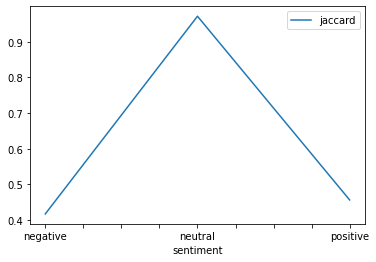

In [ ]:
plt_df = X_val[['predicted_selection','sentiment','jaccard']]
plt_df.groupby(['sentiment']).mean().plot()

In [ ]:
import matplotlib.pyplot as plt


top_words = X_val[['predicted_selection']].value_counts()

top_words[:10].plot(kind='bar') #top thne words all sentiments

In [ ]:
import html

### The jaccard similarity score is: 0.6625123273340392


In [ ]:
X_val.head(8)

,textID,text,selected_text,sentiment,predicted_selection,jaccard
20673,3391184efc,loves the nice weather and 7:30 exams,loves,positive,loves the nice,0.333333
12581,b35daf9677,"okay, this weather isn`t 'cute sundress' frien...","Okay, this weather isn`t 'cute sundress' frien...",neutral,"okay, this weather isn`t 'cute sundress' frien...",1.000000
13136,06e5249859,woo hoo!! congratulations,Congratulations,positive,congratulations,1.000000
14013,3cd4960670,thanks got a hold of someone there who knew...,thanks,positive,thanks,1.000000
25030,92b75314ca,got back and putting in the laundry. we got in...,Got back and putting in the laundry. We got in...,neutral,got back and putting in the laundry. we got in...,1.000000
19380,7438c9c09a,congrats on graduating college!,CONGRATS,positive,congrats,1.000000
17226,fa042d9ad5,can you get me a sub from subway when ur on yo...,Can you get me a sub from subway when ur on yo...,neutral,can you get me a sub from subway when ur on yo...,1.000000
10078,a4ede54987,it`s the weekend but 9 year old is grounded wh...,it`s the weekend but 9 year old is grounded wh...,neutral,it`s the weekend but 9 year old is grounded wh...,1.000000


In [ ]:
pos_tr = train[train['sentiment'] == 'positive']
neutral_tr = train[train['sentiment'] == 'neutral']
neg_tr = train[train['sentiment'] == 'negative']

In [ ]:
pos_tr1 = X_val[X_val['sentiment'] == 'positive']
neutral_tr1 = X_val[X_val['sentiment'] == 'neutral']
neg_tr1 = X_val[X_val['sentiment'] == 'negative']

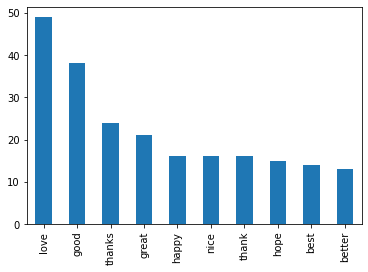

In [ ]:
pos_tr_viz = pos_tr1['predicted_selection'].value_counts()
pos_tr_viz = pos_tr_viz[:10].plot(kind='bar')

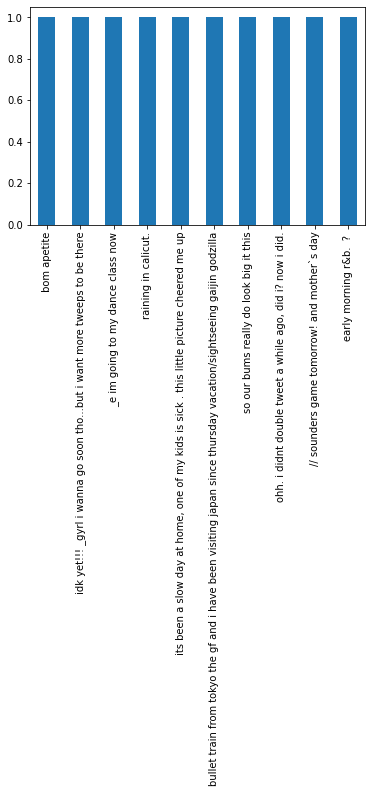

In [ ]:
neutral_tr_viz = neutral_tr1['predicted_selection'].value_counts()
neutral_tr_viz = neutral_tr_viz[:10].plot(kind='bar')

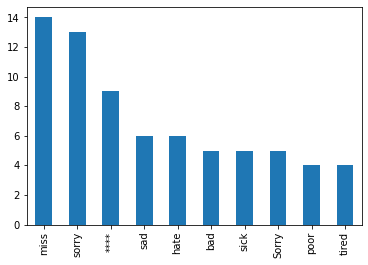

In [ ]:
neg_tr_viz = neg_tr1['selected_text'].value_counts()
neg_tr_viz = neg_tr_viz[:10].plot(kind='bar')

In [23]:
cv = CountVectorizer(analyzer='word',max_df=0.95, min_df=2,stop_words='english')

final_cv = cv.fit_transform(train['text'])

X_pos = cv.transform(pos_tr['text'])
X_neutral = cv.transform(neutral_tr['text'])
X_neg = cv.transform(neg_tr['text'])

pos_final_count_df = pd.DataFrame(X_pos.toarray(), columns=cv.get_feature_names())
neutral_final_count_df = pd.DataFrame(X_neutral.toarray(), columns=cv.get_feature_names())
neg_final_count_df = pd.DataFrame(X_neg.toarray(), columns=cv.get_feature_names())

NameError: ignored

In [ ]:
pos_words = {}
neutral_words = {}
neg_words = {}

for k in cv.get_feature_names():
    pos = pos_final_count_df[k].sum()
    neutral = neutral_final_count_df[k].sum()
    neg = neg_final_count_df[k].sum()
    
    pos_words[k] = pos/(pos_tr.shape[0])
    neutral_words[k] = neutral/(neutral_tr.shape[0])
    neg_words[k] = neg/(neg_tr.shape[0])

In [ ]:
neg_words_adj = {}
pos_words_adj = {}
neutral_words_adj = {}

for key, value in neg_words.items():
    neg_words_adj[key] = neg_words[key] - (neutral_words[key] + pos_words[key])
    
for key, value in pos_words.items():
    pos_words_adj[key] = pos_words[key] - (neutral_words[key] + neg_words[key])
    
for key, value in neutral_words.items():
    neutral_words_adj[key] = neutral_words[key] - (neg_words[key] + pos_words[key])

In [26]:
neg_words_adj

{'00': 0.0004005329478390361,
 '000': -0.000981924423100068,
 '000th': -0.00010039152695512498,
 '00am': 0.00014206563432305724,
 '00pm': -0.00012933264355923435,
 '01': 4.167410736793226e-05,
 '02': -0.00010039152695512498,
 '024': 0.00014206563432305724,
 '03': 0.0001837397416909895,
 '04': -4.5984428823369825e-05,
 '05': -0.0002467674827336198,
 '06': 8.334821473586452e-05,
 '060': -0.00010039152695512498,
 '0600': 0.00014206563432305724,
 '06am': -0.00012933264355923435,
 '07': 0.00015479862508688014,
 '07am': 0.00014206563432305724,
 '08': -0.000690007697922052,
 '09': -0.0006772747071582292,
 '0_o': -0.00012933264355923435,
 '0f': -0.00010039152695512498,
 '0ghz': -0.00012933264355923435,
 '0k': -0.00012933264355923435,
 '0n': -0.00010039152695512498,
 '0rpm': -0.00010039152695512498,
 '0ut': 0.00014206563432305724,
 '10': -0.004174025935959896,
 '100': -0.0029082115097852183,
 '1000': -0.00020509337536568748,
 '10000000000': 0.00014206563432305724,
 '1000000000000000000000000000